In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#Importing necessary libraries.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
%matplotlib inline

In [5]:
train = pd.read_csv("/Users/jesusaguirre/Desktop/Code/Data Viz/Loan Prediction/archive/Training Data.csv")
test = pd.read_csv('/Users/jesusaguirre/Desktop/Code/Data Viz/Loan Prediction/archive/Test Data.csv')

In [6]:
train.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


In [8]:
train.shape

(252000, 13)

In [9]:
test.head()

,ID,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
0,1,7393090,59,19,single,rented,no,Geologist,Malda,West Bengal,4,13
1,2,1215004,25,5,single,rented,no,Firefighter,Jalna,Maharashtra,5,10
2,3,8901342,50,12,single,rented,no,Lawyer,Thane,Maharashtra,9,14
3,4,1944421,49,9,married,rented,yes,Analyst,Latur,Maharashtra,3,12
4,5,13429,25,18,single,rented,yes,Comedian,Berhampore,West Bengal,13,11


 # Exploratory Analysis

Text(0.5, 1.0, 'Final Application Status')

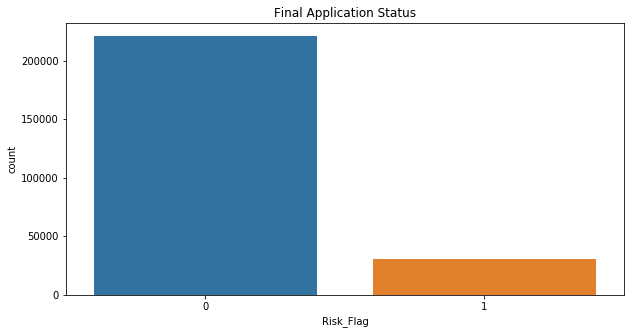

In [10]:
fig = plt.figure(figsize = (10,5))
sns.countplot(train['Risk_Flag'])
plt.title('Final Application Status')

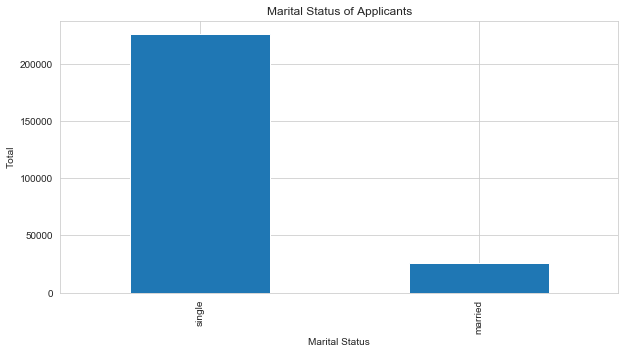

In [11]:
fig = plt.figure(figsize = (10,5))
sns.set_style("whitegrid")
plt.xlabel('Marital Status')
plt.ylabel('Total')
plt.title('Marital Status of Applicants')
train['Married/Single'].value_counts().plot(kind='bar')

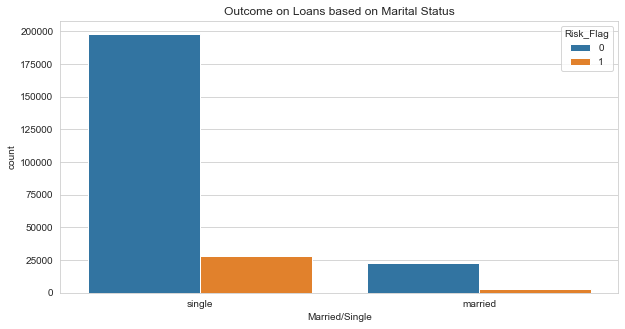

In [12]:
fig = plt.figure(figsize = (10,5))
plt.title('Outcome on Loans based on Marital Status')
sns.countplot(train['Married/Single'], hue = train['Risk_Flag'])

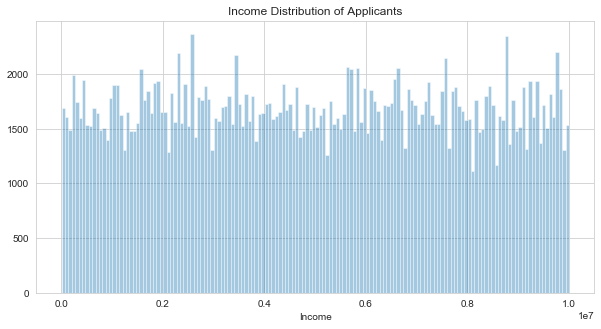

In [14]:
fig = plt.figure(figsize = (10,5))
plt.rcParams["patch.force_edgecolor"] = True
plt.title('Income Distribution of Applicants')
sns.distplot(train['Income'], bins = 150, kde = False)

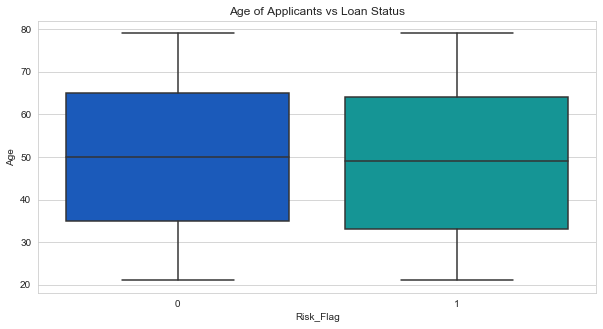

In [15]:
fig = plt.figure(figsize = (10,5))
plt.title('Age of Applicants vs Loan Status')
sns.boxplot(x='Risk_Flag',y='Age',data=train,palette='winter')

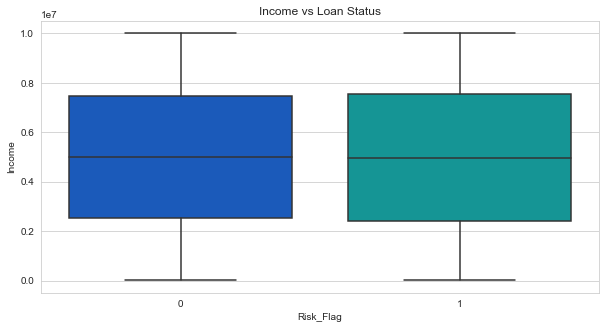

In [16]:
fig = plt.figure(figsize = (10,5))
plt.title('Income vs Loan Status')
sns.boxplot(x='Risk_Flag',y='Income',data=train,palette='winter')

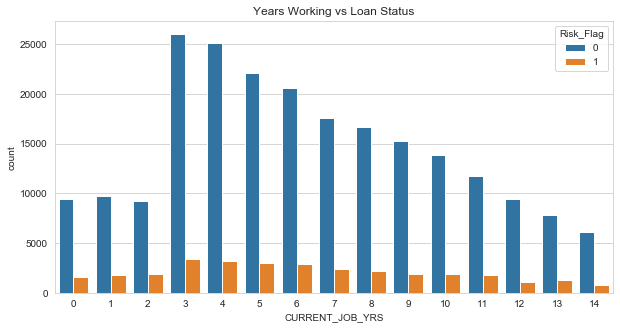

In [17]:
fig = plt.figure(figsize = (10,5))
plt.title('Years Working vs Loan Status')
sns.countplot(train['CURRENT_JOB_YRS'], hue = train['Risk_Flag'])

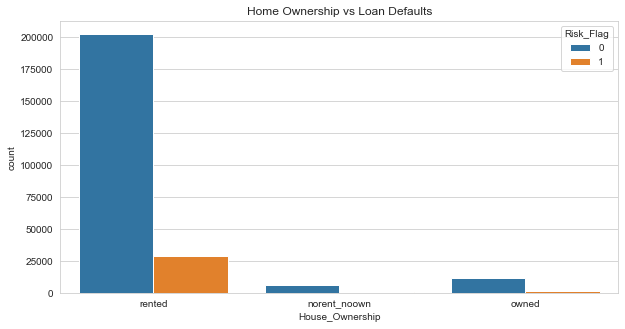

In [18]:
fig = plt.figure(figsize = (10,5))
plt.title('Home Ownership vs Loan Defaults')
sns.countplot(train['House_Ownership'], hue = train['Risk_Flag'])

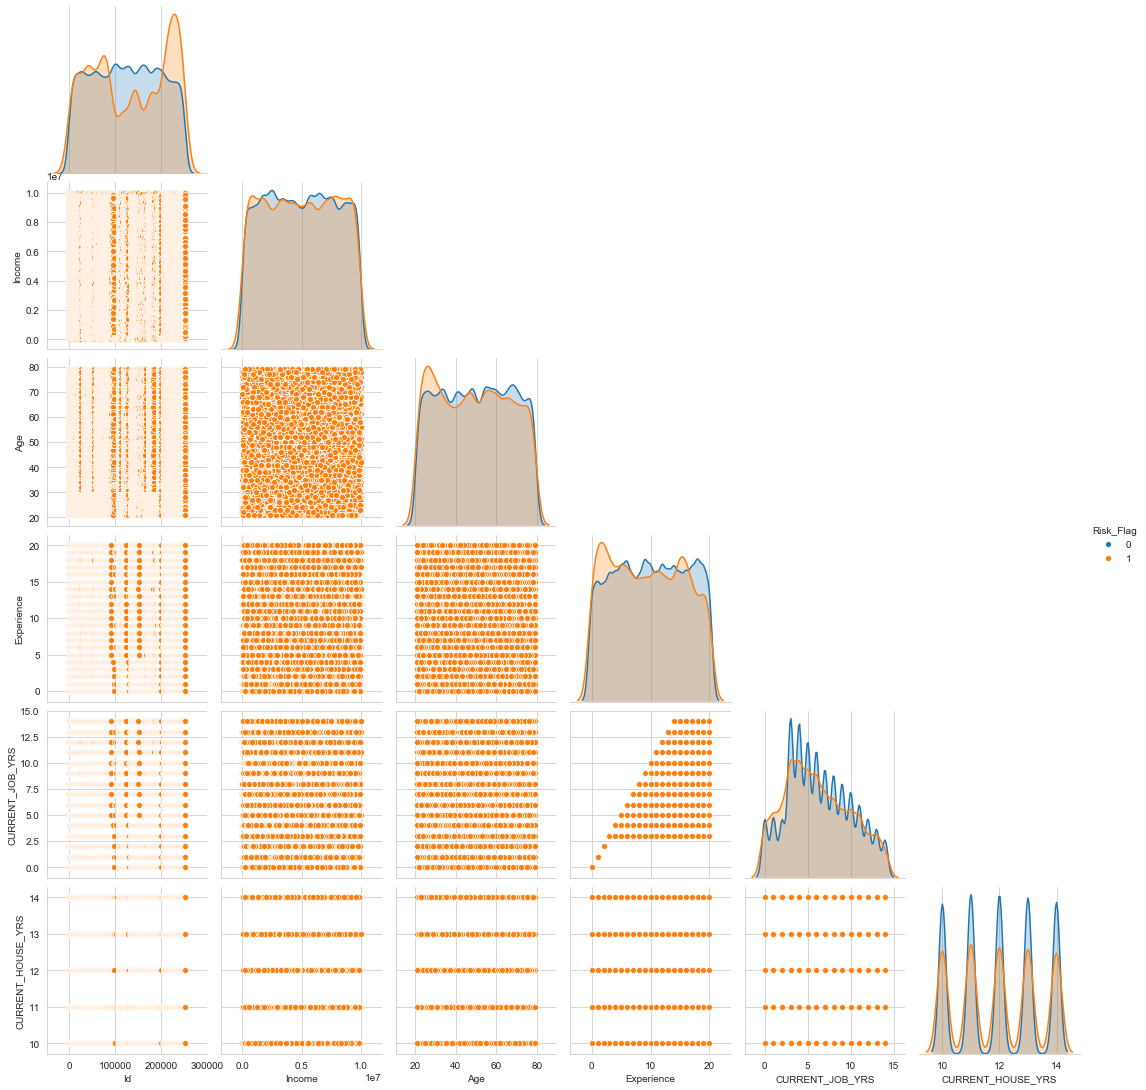

In [19]:
sns.pairplot(data = train,kind = 'scatter',corner = 'True', hue = 'Risk_Flag')

No linear relationship with any of the features provided with respect to the target variable.

Text(0.5, 1.0, 'Applications Per State')

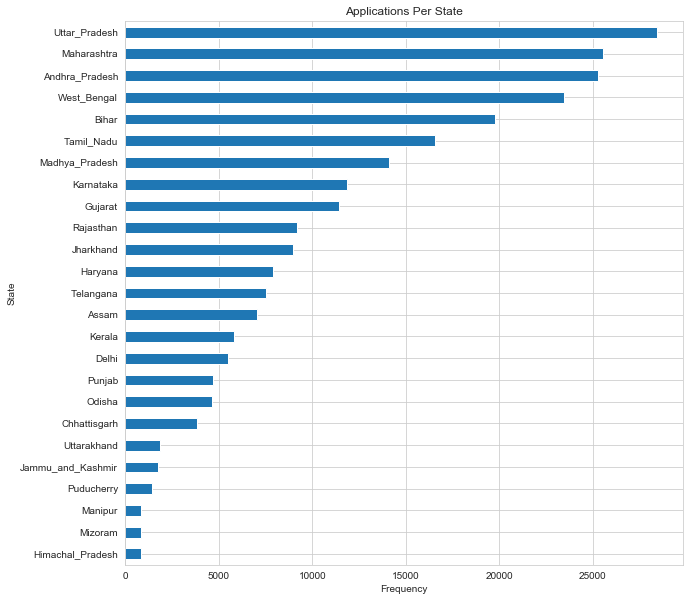

In [20]:
plt.figure(figsize = (10,10))
train['STATE'].value_counts()[:25].plot(kind='barh').invert_yaxis()
plt.xlabel('Frequency')
plt.ylabel('State')
plt.title('Applications Per State')

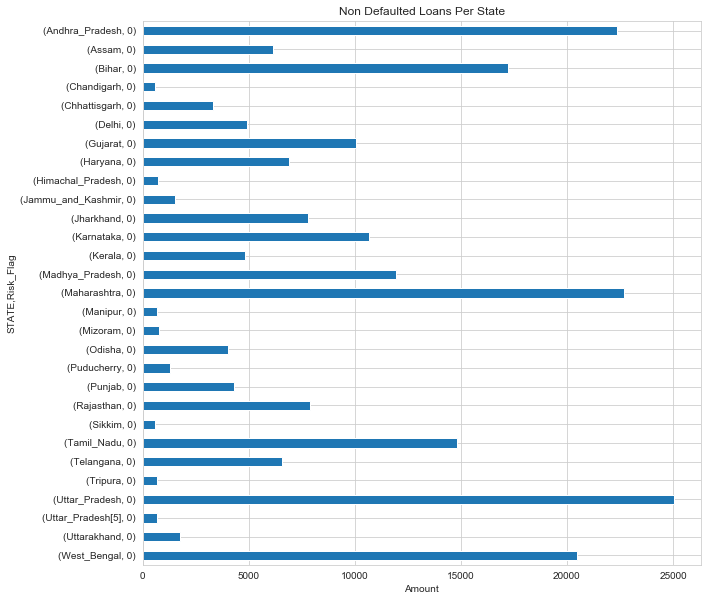

In [21]:
state_risk_flags = train.groupby('STATE')['Risk_Flag'].value_counts()
plt.figure(figsize = (10,10))
plt.xlabel('Amount')
plt.title('Non Defaulted Loans Per State')
state_risk_flags[::2].plot(kind = 'barh').invert_yaxis()

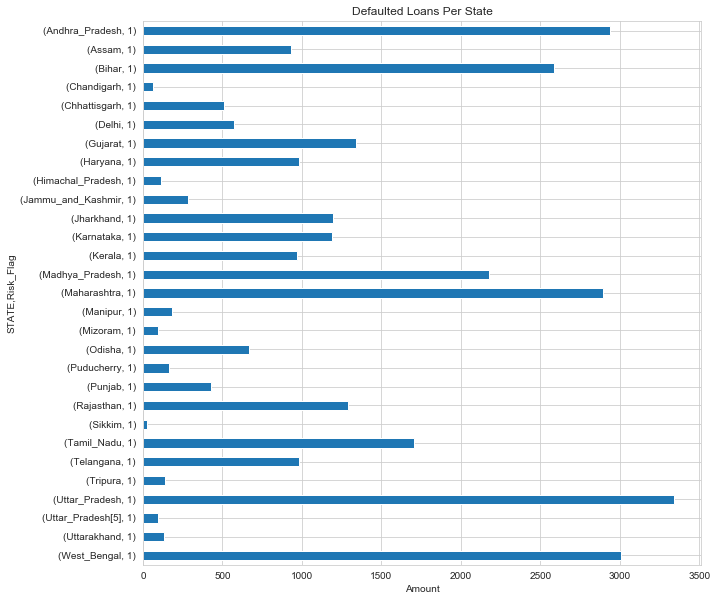

In [22]:
plt.figure(figsize = (10,10))
plt.xlabel('Amount')
plt.title('Defaulted Loans Per State')
state_risk_flags[1::2].plot(kind = 'barh').invert_yaxis()

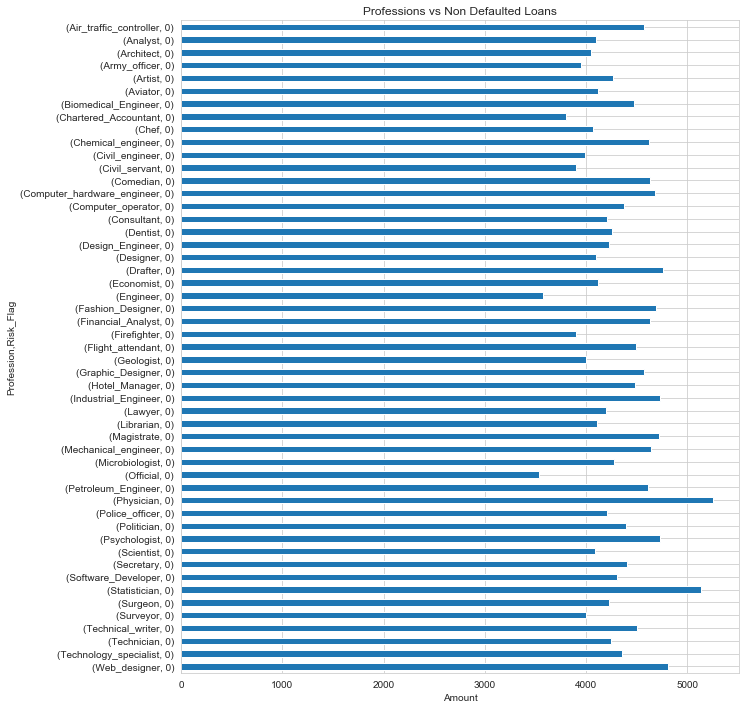

In [23]:
plt.figure(figsize = (10,12))
plt.ylabel('Profession')
plt.xlabel('Amount')
plt.title('Professions vs Non Defaulted Loans')
train.groupby('Profession')['Risk_Flag'].value_counts()[::2].plot(kind = 'barh').invert_yaxis()

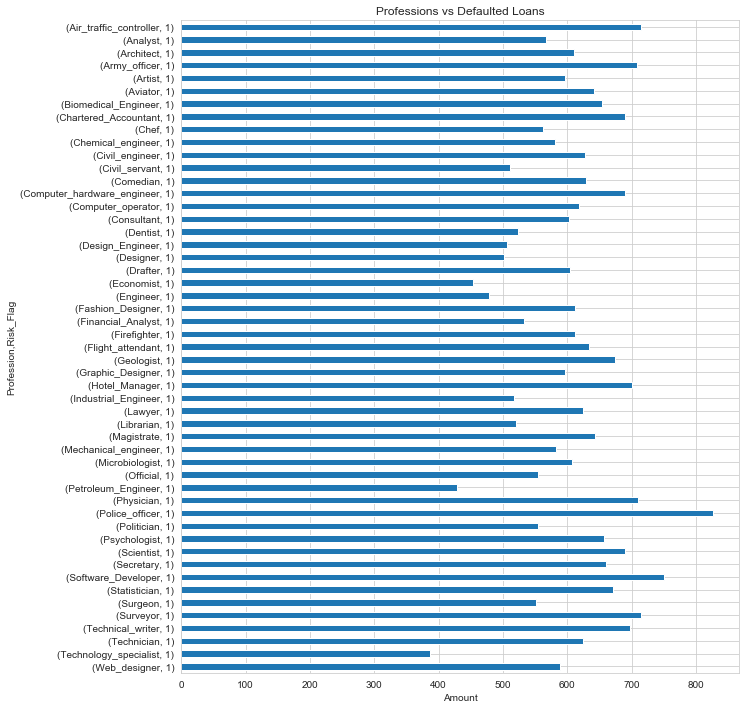

In [24]:
plt.figure(figsize = (10,12))
plt.ylabel('Profession')
plt.xlabel('Amount')
plt.title('Professions vs Defaulted Loans')
train.groupby('Profession')['Risk_Flag'].value_counts()[1::2].plot(kind = 'barh').invert_yaxis()

What we've found out so far:
1. Uttar Pradesh has had the highest number of loan applications thus far (including defaulted/non defaulted)
2. Physicians is the profession most likely to not default on their loan.
    - STEM professions give you the best opportunity to not default on future loans.
3. Police officers have a higher risk of defaulting on their loans.
4. Defaulting on a loan does mirror (albeit big gap) the number of years on the job.
5. Renting an apartment as opposed to renting/owning a house has shown to be more indicative of defaulting on loans.

## Checking for missing data

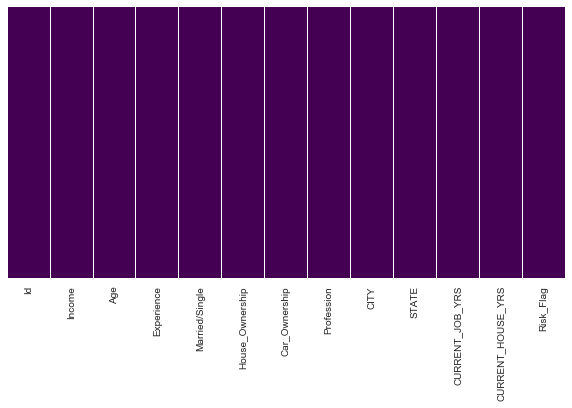

In [25]:
plt.figure(figsize = (10,5))
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

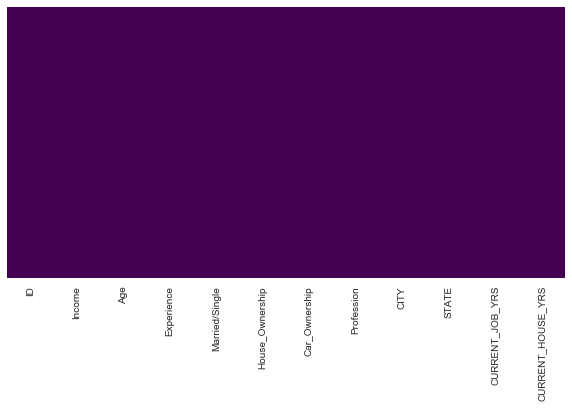

In [26]:
plt.figure(figsize = (10,5))
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis')

To take care of the categorical data we can apply the get dummies method to assign a number to each of the variables.

In [27]:
train.drop(['Profession','CITY','STATE'], axis = 1, inplace = True)

In [28]:
car_ownership = pd.get_dummies(train['Car_Ownership'], drop_first  = True)
house_ownership = pd.get_dummies(train['House_Ownership'])
married_single = pd.get_dummies(train['Married/Single'],drop_first=True)

In [29]:
train.drop(['Car_Ownership','House_Ownership','Married/Single'],axis=1,inplace=True)

In [30]:
train = pd.concat([train,car_ownership,house_ownership,married_single],axis = 1)

In [31]:
train.head()

,Id,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,yes,norent_noown,owned,rented,single
0,1,1303834,23,3,3,13,0,0,0,0,1,1
1,2,7574516,40,10,9,13,0,0,0,0,1,1
2,3,3991815,66,4,4,10,0,0,0,0,1,0
3,4,6256451,41,2,2,12,1,1,0,0,1,1
4,5,5768871,47,11,3,14,1,0,0,0,1,1


In [32]:
car_ownership = pd.get_dummies(test['Car_Ownership'], drop_first  = True)
house_ownership = pd.get_dummies(test['House_Ownership'])
married_single = pd.get_dummies(test['Married/Single'],drop_first=True)

In [33]:
test.drop(['Car_Ownership','House_Ownership','Married/Single'],axis=1,inplace=True)
test = pd.concat([test,car_ownership,house_ownership,married_single],axis = 1)

In [34]:
test.drop(['Profession','CITY','STATE'], axis = 1, inplace = True)

In [35]:
test.head()

,ID,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,yes,norent_noown,owned,rented,single
0,1,7393090,59,19,4,13,0,0,0,1,1
1,2,1215004,25,5,5,10,0,0,0,1,1
2,3,8901342,50,12,9,14,0,0,0,1,1
3,4,1944421,49,9,3,12,1,0,0,1,0
4,5,13429,25,18,13,11,1,0,0,1,1


In [36]:
X = train.drop(['Risk_Flag'], axis = 1)
y = train['Risk_Flag']
y.value_counts()

0    221004
1     30996
Name: Risk_Flag, dtype: int64

In [37]:
ros = RandomOverSampler()
X, y = ros.fit_resample(X,y)
y.value_counts()

1    221004
0    221004
Name: Risk_Flag, dtype: int64

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state = 101)

In [39]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

In [40]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.52      0.41      0.46     22080
           1       0.51      0.62      0.56     22121

    accuracy                           0.51     44201
   macro avg       0.51      0.51      0.51     44201
weighted avg       0.51      0.51      0.51     44201



In [41]:
rfc = RandomForestClassifier(n_estimators = 650)
rfc.fit(X_train,y_train)
pred = rfc.predict(X_test)

In [42]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     22080
           1       0.97      1.00      0.98     22121

    accuracy                           0.98     44201
   macro avg       0.98      0.98      0.98     44201
weighted avg       0.98      0.98      0.98     44201



In [43]:
import xgboost as xgb
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [44]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [45]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), 
                    gamma = space['gamma'], reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [46]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.6890115608244157                                     
SCORE:                                                                            
0.6141263772312844                                                                
SCORE:                                                                            
0.6462975950770344                                                                
SCORE:                                                                            
0.6757313182959661                                                                
SCORE:                                                                            
0.6807085812538178                                                                
SCORE:                                                                            
0.6703242008099364                                                                
SCORE:                                                    

SCORE:                                                                             
0.7024954186556865                                                                 
SCORE:                                                                             
0.7103685436981064                                                                 
SCORE:                                                                             
0.6224972285694894                                                                 
SCORE:                                                                             
0.6750752245424312                                                                 
SCORE:                                                                             
0.6619307255491957                                                                 
SCORE:                                                                             
0.6820886405284948                                                          

0.6244655098300943                                                                 
SCORE:                                                                             
0.6703694486550078                                                                 
SCORE:                                                                             
0.6979480102260129                                                                 
100%|██████████| 100/100 [49:00<00:00, 29.40s/trial, best loss: -0.7184452840433474]


In [47]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.7045616294411168, 'gamma': 7.465492722898423, 'max_depth': 18.0, 'min_child_weight': 10.0, 'reg_alpha': 42.0, 'reg_lambda': 0.34111200299953653}


In [48]:
xgb = XGBClassifier(colsample_bytree = 1, 
                    gamma = 7,
                    max_depth = 18, min_child_weight = 10, 
                    reg_alpha = 42, reg_lambda = 1)

In [49]:
xgb.fit(X_train,y_train)
predxg = xgb.predict(X_test)

In [50]:
print(classification_report(y_test,predxg))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91     22080
           1       0.86      1.00      0.92     22121

    accuracy                           0.91     44201
   macro avg       0.93      0.91      0.91     44201
weighted avg       0.93      0.91      0.91     44201



In [51]:
print(roc_auc_score(y_test,predxg))

0.9147200423199412


In [56]:
test.rename(columns = {'ID':'Id'}, inplace = True)

In [57]:
test_data_pred = xgb.predict(test)

In [61]:
my_submission = pd.DataFrame({'id': test['Id'], 'risk_flag': test_data_pred})
my_submission.to_csv('submission.csv', index=False)